# Report

Sprawozdanie z projektu zawierające porównanie Wielomodalenego Autoenkodera i Wielomodalnego Autoenkodera Wariacyjnego.

## Importy

In [1]:
from typing import Dict, List, Type

import pandas as pd
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from abc import abstractmethod
import os
from src.dataset import MyDataset, DataModule
from src.multimodal_ae import (
    MultimodalEncoder,
    AvgFusion,
    MLPFusion,
    MultimodalDecoder,
    BaseAE,
    MultimodalAE,
)
from src.multimodal_vae import (
    Swish,
    Encoder,
    Decoder,
    ProductOfExperts,
    BaseVAE,
    MVAE,
)
from src.utils import (
    extract_multimodal_ae_embeddings,
    extract_multimodal_vae_embeddings,
    visualize_most_similar,
)
from src.train import train_model

Found cached dataset cc6204-hackaton-cub-dataset (/home/cicheck/.cache/huggingface/datasets/alkzar90___cc6204-hackaton-cub-dataset/default/0.0.0/de850c9086bff0dd6d6eab90f79346241178f65e1a016a50eec240ae9cdf2064)


  0%|          | 0/2 [00:00<?, ?it/s]

## Constants

In [2]:
CUBE_N_CLASSES = 200
MEME_N_CLASSES = 2
IMG_REPREZENTATION_SIZE = 2048
TEXT_REPREZENTATION_SIZE = 384

## Zbiory danych

In [3]:
cube_datamodule = DataModule(
    train_path="data/cub/preprocessed_train.pkl",
    test_path="data/cub/preprocessed_test.pkl",
    batch_size=64,
)

In [4]:
cube_df = cube_datamodule.df["all"]

In [5]:
meme_datamodule = DataModule(
    train_path="data/heatfull_meme/preprocessed_train.pkl",
    test_path="data/heatfull_meme/preprocessed_test.pkl",
    batch_size=64,
)

In [6]:
meme_df = meme_datamodule.df["all"]

## Analiza reprezentacji wielomodalnego autokodera dla domyślnych hiperparametrów

In [7]:
default_mae_hparams = {
    "encoder_cls": MultimodalEncoder,
    "modality_names": ["img_emb", "text_emb"],
    "data_dims": {"img_emb": 2048, "text_emb": 384}, 
    "batch_size": 64,
    "num_epochs": 5,
    "hidden_dims": [256, 256, 256],
    "emb_dim": 128,
    "lr": 1e-3,
    "weight_decay": 5e-4,
}

### Trening

In [11]:
train_model(
    model_cls=MultimodalAE,
    hparams={
        "name": "CubeImageTextAvgAE",
        "fusion": "Avg",
        **default_mae_hparams,
    },
    datamodule=cube_datamodule,
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/CubeImageTextAvgAE
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder | 954 K 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)
/home/cicheck/.pyenv/versions/3.10.2/envs/representation/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the numb

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/cicheck/.pyenv/versions/3.10.2/envs/representation/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning: You called `self.log('step', ...)` in your `validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/cicheck/.pyenv/versions/3.10.2/envs/representation/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning: You called `self.log('step', ...)` in your `training_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
Epoch 0, global step 0: 'val/loss' reached 0.00009 (best 0.00009), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/CubeImageTextAvgAE/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00006 (best 0.00006), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/CubeImageTextAvgAE/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00005 (best 0.00005), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/CubeImageTextAvgAE/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00004 (best 0.00004), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/CubeImageTextAvgAE/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00004 (best 0.00004), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/CubeImageTextAvgAE/model.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


In [12]:
train_model(
    model_cls=MultimodalAE,
    hparams={
        "name": "MemeImageTextAvgAE",
        "fusion": "Avg",
        **default_mae_hparams,
    },
    datamodule=meme_datamodule,
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/MemeImageTextAvgAE
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder | 954 K 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/MemeImageTextAvgAE/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00045 (best 0.00045), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/MemeImageTextAvgAE/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00042 (best 0.00042), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/MemeImageTextAvgAE/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00040 (best 0.00040), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/MemeImageTextAvgAE/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/MemeImageTextAvgAE/model.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


### Ekstrakcja wektorów osadzeń

In [7]:
cube_z = extract_multimodal_ae_embeddings(
    MultimodalAE,
    datamodule=cube_datamodule,
    name="CubeImageTextAvgAE",
)

In [8]:
meme_z = extract_multimodal_ae_embeddings(
    MultimodalAE,
    datamodule=meme_datamodule,
    name="MemeImageTextAvgAE",
)

### Wizualizacja

Anchor: anne frank writing in her diary
4798: this is anne frank in june 1929
7841: anne frank smiling
1853: anne frank passed away february 1945
1921: just ordered the new anne frank puzzle
117: just ordered the new anne frank puzzle


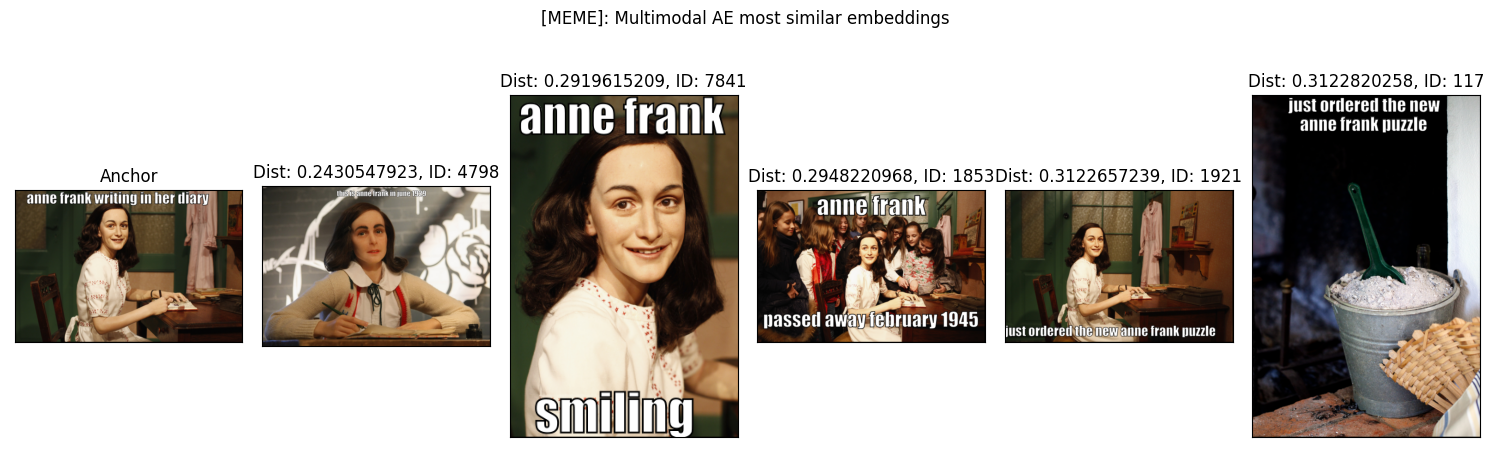

In [10]:
_ = visualize_most_similar(
    df=meme_df,
    title="[MEME]: Multimodal AE most similar embeddings",
    anchor_index=200,
    z=meme_z.cpu(),
    dataset="hatefull",
)

Anchor: a black bird with a grey belly and a white stripe on the tip of it's cheek pattern also has short, orange bill.
19024: the bird has a curved bill that is yellow and black as well as a grey back.
88482: the bird has black and grey coverts with a very long and slender orange bill.
113875: the bird has a long black bill, a small yellow tuft on its crown, and a dark gray back with white stripes.
51196: a colorful bird with white throat, black crown and grey belly and the bill is short and pointed
10026: this bird has a short, yellow bill with a grey white crown, dark brown with black spots side and pink with black stops belly.


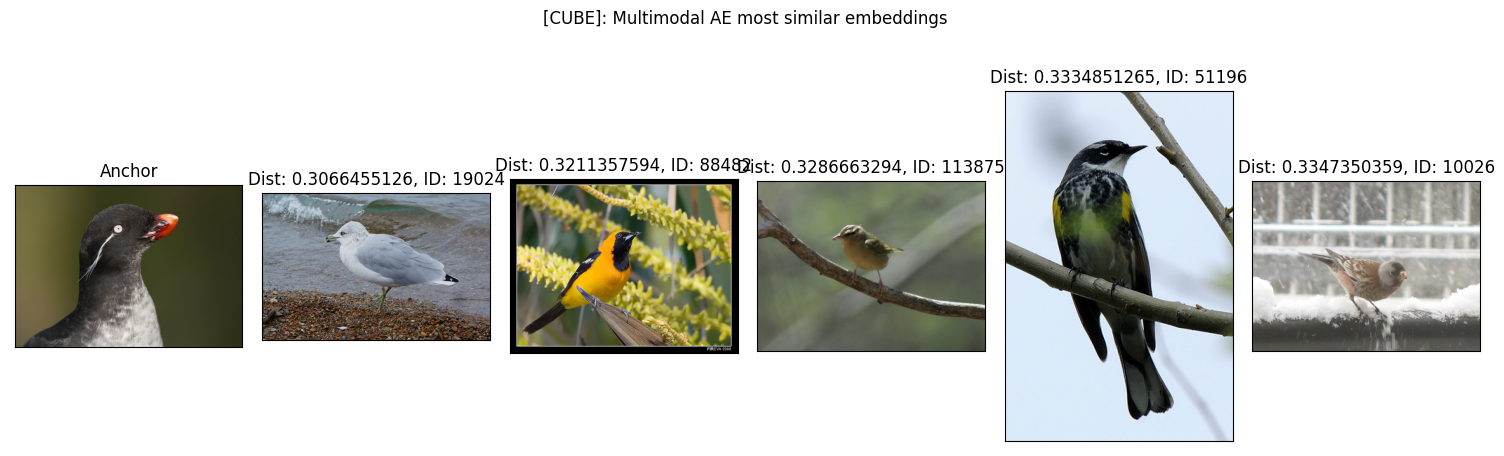

In [9]:
_ = visualize_most_similar(
    df=cube_df,
    title="[CUBE]: Multimodal AE most similar embeddings",
    anchor_index=2001,
    z=cube_z.cpu(),
)

## Analiza reprezentacji wielomodalnego  wariacyjnego autokodera dla domyślnych hiperparametrów

In [8]:
default_mvae_hparams = {
    "data_dims": {"image": 2048, "text": 384}, 
    "batch_size": 64,
    "num_epochs": 3,
    "hidden_dims": {
        "image": [1024, 512, 256],#lst[::-1]
        "text": [256, 256, 256],
    },
    "emb_dim": 128,
    "lr": 1e-4,
    "weight_decay": 5e-4,
}

### Trening

In [13]:
train_model(
    model_cls=MVAE,
    hparams={
        "name": "CubeImageTextAvgVAE",
        "activation" : Swish,
        "lambda_image" : 1.0,
        "lambda_text" : 1.0,
        "annealing_factor" : 1.0,
        **default_mvae_hparams,
    },
    datamodule=cube_datamodule,
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/CubeImageTextAvgVAE
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 2.8 M 
1 | image_decoder      | Decoder          | 2.8 M 
2 | text_encoder       | Encoder          | 295 K 
3 | text_decoder       | Decoder          | 263 K 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.674    Total estimated model params size (MB)
/home/cicheck/.pyenv/versions/3.10.2/envs/representation/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloa

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/cicheck/.pyenv/versions/3.10.2/envs/representation/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning: You called `self.log('step', ...)` in your `validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/cicheck/.pyenv/versions/3.10.2/envs/representation/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning: You called `self.log('step', ...)` in your `training_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
Epoch 0, global step 0: 'val/loss' reached 0.00398 (best 0.00398), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/CubeImageTextAvgVAE/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00240 (best 0.00240), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/CubeImageTextAvgVAE/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00210 (best 0.00210), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/CubeImageTextAvgVAE/model.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=3` reached.


In [14]:
train_model(
    model_cls=MVAE,
    hparams={
        "name": "MemeImageTextAvgVAE",
        "activation" : Swish,
        "lambda_image" : 1.0,
        "lambda_text" : 1.0,
        "annealing_factor" : 1.0,
        **default_mvae_hparams,
    },
    datamodule=meme_datamodule,
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/MemeImageTextAvgVAE
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 2.8 M 
1 | image_decoder      | Decoder          | 2.8 M 
2 | text_encoder       | Encoder          | 295 K 
3 | text_decoder       | Decoder          | 263 K 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.674    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 2.02958 (best 2.02958), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/MemeImageTextAvgVAE/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.14564 (best 0.14564), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/MemeImageTextAvgVAE/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.07126 (best 0.07126), saving model to '/home/cicheck/projects/studies/sem2/studies-representation/reprezentacja-projekt/data/checkpoints/MemeImageTextAvgVAE/model.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=3` reached.


### Ekstrakcja wektorów osadzeń

In [15]:
cube_z = extract_multimodal_vae_embeddings(
    MVAE,
    datamodule=cube_datamodule,
    name="CubeImageTextAvgVAE",
)

In [16]:
meme_z = extract_multimodal_vae_embeddings(
    MVAE,
    datamodule=meme_datamodule,
    name="MemeImageTextAvgVAE",
)

### Wizualizacja

Anchor: anne frank writing in her diary
1363: what's the difference between jews and a loaf of bread? a loaf of bread doesn't burn in an oven
1219: a local market
1718: ancestry.com the results are in
304: you don't need an ar15 to protect yourself but he does, and this guy and this guy, and him and him and him
1360: if you got your phone wet try leaving it in dry rice overnight it will attract asians who will fix your electronics for you


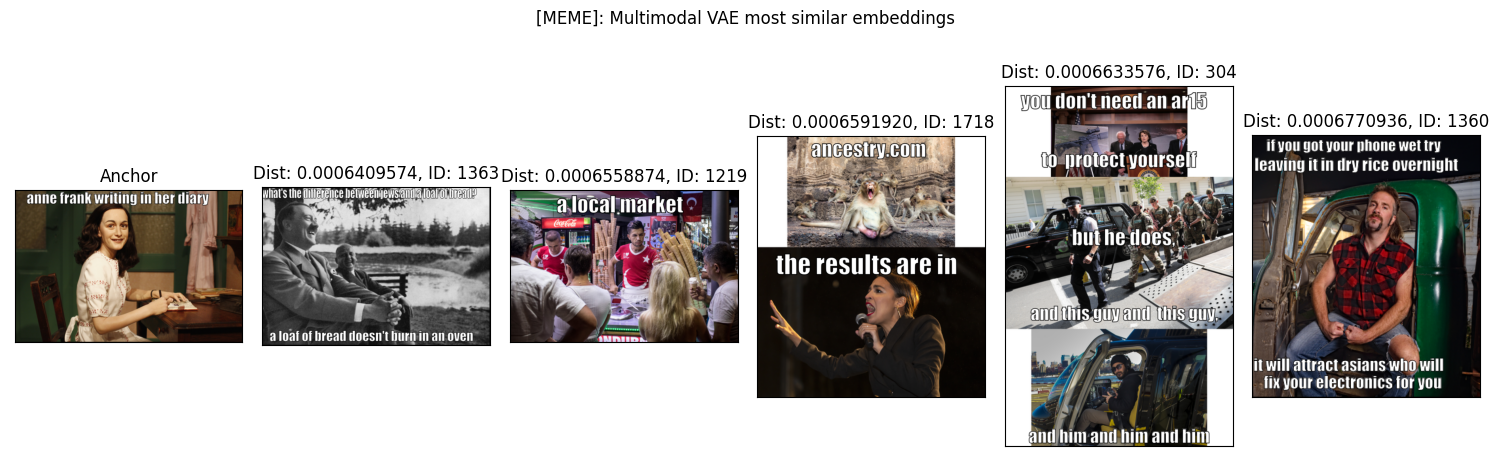

In [17]:
_ = visualize_most_similar(
    df=meme_df,
    title="[MEME]: Multimodal VAE most similar embeddings",
    anchor_index=200,
    z=meme_z.cpu(),
    dataset="hatefull",
)

Anchor: a black bird with a grey belly and a white stripe on the tip of it's cheek pattern also has short, orange bill.
10194: bird with sharp and pointed beak that is gray, and brown tarsus and feet, and white belly and abdomen
16837: bird has black head and wings with a light colored beak, white abdomen and distinctive bright red patch on its chest.
102410: a very round bird that is grey with some yellow in it's wing, a red crown, and a short pointy beak.
19615: a medium sized bird with a grey head and neck. its breast is white and the wings are all grey, with the exception of the tips of the primaries, which are white. it has a yellow bill with a red spot on the bottom of the tip.
21271: the bird has a white belly with large black wings and a grey crown with a curved grey beak.


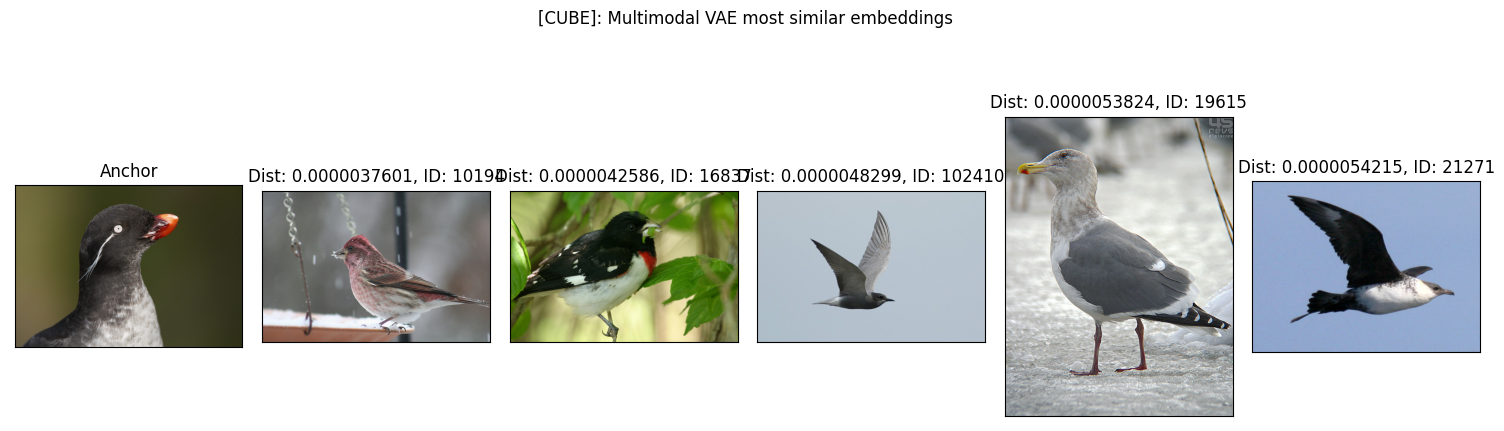

In [18]:
_ = visualize_most_similar(
    df=cube_df,
    title="[CUBE]: Multimodal VAE most similar embeddings",
    anchor_index=2001,
    z=cube_z.cpu(),
)

**KOMENTARZ**:
* Dla zbioru `hatefull_meme` możemy zaobserwować że dla wielomodalnego autokodera podobne obrazy przekładają się na "bliskie" wektory reprezentacji.
* W przypadku wielomodalnego wariacyjnego autokodera ciężko mówić o podobnej zależności.

## Klasyfikacja

### Kod modelu

In [9]:
LOG_DIR = './logs/'
os.makedirs(LOG_DIR, exist_ok=True)
LOAD_LOGS = LOG_DIR + "lightning_logs/"

In [15]:
import torchmetrics


class Classifier(pl.LightningModule):

    def __init__(
        self,
        model: pl.LightningModule,
        lr: float,
        n_classes: int,
    ) -> None:
        super().__init__()
        self.loss = torch.nn.CrossEntropyLoss()
        self.lr = lr
        self.model = model
        self.f1score = torchmetrics.F1Score(num_classes=n_classes, average="macro", multiclass=True)

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def predict_step(self, train_batch, batch_idx):
        x = train_batch
        return self(x), x["label"]
    
    def training_step(self, train_batch, batch_idx):
        x = train_batch
        y = x["label"]
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        metrics = {
            'loss/train': loss,
            "f1score/train": self.f1score(y_hat, y),
        }
        self.log_dict(metrics, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x = val_batch
        y = x["label"]
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        metrics = {
            'loss/val': loss,
            "f1score/val": self.f1score(y_hat, y),
        }
        self.log_dict(metrics, on_step=True, on_epoch=True)
        return loss

    def test_step(self, test_batch, batch_idx):
        x = test_batch
        y = x["label"]
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        metrics = {
            'loss/test': loss,
            "f1score/test": self.f1score(y_hat, y),
        }
        self.log_dict(metrics, on_step=True, on_epoch=True)
        return loss

In [11]:
from itertools import pairwise


class SingleModalityMlp(pl.LightningModule):
    def __init__(
        self, 
        lr: float,
        input_size: int,
        hidden_sizes: list[int],
        n_classes: int,
        modality: str = "img",
    ):
        super().__init__()
        assert len(hidden_sizes) > 0
        self.modality = modality
        self.model = torch.nn.Sequential()
        for index, (first_size, second_size) in enumerate(pairwise([input_size, *hidden_sizes])):
            self.model.add_module(f"linear_{index}" , nn.Linear(first_size, second_size))
            self.model.add_module(f"relu_{index}", torch.nn.ReLU())
        self.model.add_module("head" , nn.Linear(hidden_sizes[-1], n_classes))
        self.model.add_module("softmax" , nn.LogSoftmax(dim=1))

    def forward(self, x):
        if self.modality == "img":
            return self.model(x["img_emb"])
        else:
            return self.model(x["text_emb"])

In [26]:
class AutoencoderMlp(pl.LightningModule):
    def __init__(
        self,
        autoencoder,
        lr: float,
        input_size: int,
        hidden_sizes: list[int],
        n_classes: int,
    ):
        super().__init__()
        assert len(hidden_sizes) > 0
        # Freeze autoencoder
        for param in autoencoder.parameters():
            param.requires_grad = False
        self.autoencoder = autoencoder
        self.model = torch.nn.Sequential()
        for index, (first_size, second_size) in enumerate(pairwise([input_size, *hidden_sizes])):
            self.model.add_module(f"linear_{index}" , nn.Linear(first_size, second_size))
            self.model.add_module(f"relu_{index}", torch.nn.ReLU())
        self.model.add_module("head" , nn.Linear(hidden_sizes[-1], n_classes))
        self.model.add_module("softmax" , nn.LogSoftmax(dim=1))

    def forward(self, x):
        z = self.autoencoder.encode(x)
        return self.model(z)

### Klasyfikacja na oryginalnych danych

In [16]:
lr=0.001
classifier = Classifier(
    model=SingleModalityMlp(
        input_size=IMG_REPREZENTATION_SIZE,
        hidden_sizes=[1024, 512, 256, 128],
        n_classes=CUBE_N_CLASSES,
        modality="img",
        lr=lr,
    ),
    lr=lr,
    n_classes=CUBE_N_CLASSES,   
)
tb_logger = pl_loggers.TensorBoardLogger(
    save_dir=LOG_DIR,
    sub_dir="cube_mlp_baseline",
)
trainer = pl.Trainer(max_epochs=5, accelerator='gpu', devices=1, logger=tb_logger)
trainer.fit(classifier, cube_datamodule)
trainer.test(datamodule= ube_datamodule, ckpt_path="best")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | loss    | CrossEntropyLoss  | 0     
1 | model   | SingleModalityMlp | 2.8 M 
2 | f1score | F1Score           | 0     
----------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.252    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_3/checkpoints/epoch=4-step=4680.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_3/checkpoints/epoch=4-step=4680.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   f1score/test_epoch      0.004257894121110439
     loss/test_epoch         5.298380374908447
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'loss/test_epoch': 5.298380374908447,
  'f1score/test_epoch': 0.004257894121110439}]

#### Przegląd parametrów

#### Finalny model

### Klasyfikacja przy użyciu wielomodalnego autokodera

In [29]:
lr=0.001
classifier = Classifier(
    model=AutoencoderMlp(
        autoencoder=MultimodalAE.load_from_checkpoint(
            checkpoint_path=f"./data/checkpoints/CubeImageTextAvgAE/model.ckpt",
            use_cuda=True,
        ),
        input_size=128,
        hidden_sizes=[128, 128, 128],
        n_classes=CUBE_N_CLASSES,
        lr=lr,
    ),
    lr=lr,
    n_classes=CUBE_N_CLASSES,
)
tb_logger = tb_logger = pl_loggers.TensorBoardLogger(
    save_dir=LOG_DIR,
    sub_dir="cube_ae_mlp_baseline",
)
trainer = pl.Trainer(max_epochs=5, accelerator='gpu', devices=1, logger=tb_logger)
trainer.fit(classifier, cube_datamodule)
trainer.test(datamodule = cube_datamodule, ckpt_path="best")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | AutoencoderMlp   | 2.8 M 
2 | f1score | F1Score          | 0     
---------------------------------------------
846 K     Trainable params
1.9 M     Non-trainable params
2.8 M     Total params
11.013    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/cicheck/.pyenv/versions/3.10.2/envs/representation/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_4/checkpoints/epoch=4-step=4680.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_4/checkpoints/epoch=4-step=4680.ckpt
/home/cicheck/.pyenv/versions/3.10.2/envs/representation/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   f1score/test_epoch      0.011468525975942612
     loss/test_epoch         3.734827756881714
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'loss/test_epoch': 3.734827756881714,
  'f1score/test_epoch': 0.011468525975942612}]

#### Przegląd parametrów

#### Finalny model

### Klasyfikacja przy użyciu wielomodalnego wariacyjnego autokodera

In [30]:
lr=0.001
classifier = Classifier(
    model=AutoencoderMlp(
        autoencoder=MVAE.load_from_checkpoint(
            checkpoint_path=f"./data/checkpoints/CubeImageTextAvgVAE/model.ckpt",
            use_cuda=True,
        ),
        input_size=128,
        hidden_sizes=[128, 128, 128],
        n_classes=CUBE_N_CLASSES,
        lr=lr,
    ),
    lr=lr,
    n_classes=CUBE_N_CLASSES,
)
tb_logger = tb_logger = pl_loggers.TensorBoardLogger(
    save_dir=LOG_DIR,
    sub_dir="cube_vae_mlp_baseline",
)
trainer = pl.Trainer(max_epochs=5, accelerator='gpu', devices=1, logger=tb_logger)
trainer.fit(classifier, cube_datamodule)
trainer.test(datamodule = cube_datamodule, ckpt_path="best")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | model   | AutoencoderMlp   | 6.2 M 
2 | f1score | F1Score          | 0     
---------------------------------------------
75.3 K    Trainable params
6.2 M     Non-trainable params
6.2 M     Total params
24.975    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_5/checkpoints/epoch=4-step=4680.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_5/checkpoints/epoch=4-step=4680.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   f1score/test_epoch      0.004327741917222738
     loss/test_epoch         5.29826545715332
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'loss/test_epoch': 5.29826545715332,
  'f1score/test_epoch': 0.004327741917222738}]

#### Przegląd parametrów

### Finalny model

## Ostateczne zestawienie wyników